In [0]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/muhammadroshaanriaz/students-performance-dataset-cleaned

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10182  100 10182    0     0  34515      0 --:--:-- --:--:-- --:--:-- 34515


In [0]:
!unzip -o archive.zip -d students-performance-dataset-cleaned

Archive:  archive.zip
  inflating: students-performance-dataset-cleaned/Cleaned_Students_Performance.csv  


In [0]:
import numpy as np
import pandas as pd

students_performance_df_orig = pd.read_csv('students-performance-dataset-cleaned/Cleaned_Students_Performance.csv')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
students_performance_df_orig['race_ethnicity'] = label_encoder.fit_transform(students_performance_df_orig['race_ethnicity'])
students_performance_df_orig['parental_level_of_education'] = label_encoder.fit_transform(students_performance_df_orig['parental_level_of_education'])

students_performance_df = students_performance_df_orig.drop(['average_score', 'total_score'], axis=1)
students_performance_df

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,0,1,1,1,0,72,72,74
1,0,2,4,1,1,69,90,88
2,0,1,3,1,0,90,95,93
3,1,0,0,0,0,47,57,44
4,1,2,4,1,0,76,78,75
...,...,...,...,...,...,...,...,...
995,0,4,3,1,1,88,99,95
996,1,2,2,0,0,62,55,55
997,0,2,2,0,1,59,71,65
998,0,3,4,1,1,68,78,77


In [0]:
colors = np.array(["blue", "red", "green", "purple", "orange", "yello", "black"])

z = np.array(students_performance_df_orig['average_score'].map(lambda average_score: 0 if average_score < 70 else 1 if average_score < 80 else 2 if average_score < 90 else 3), dtype=np.int8)

In [0]:
students_performance_df.values

Out[18]: array([[ 0,  1,  1, ..., 72, 72, 74],
       [ 0,  2,  4, ..., 69, 90, 88],
       [ 0,  1,  3, ..., 90, 95, 93],
       ...,
       [ 0,  2,  2, ..., 59, 71, 65],
       [ 0,  3,  4, ..., 68, 78, 77],
       [ 0,  3,  4, ..., 77, 86, 86]])

In [0]:
def estimate_covariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    #<FILL IN>
    data_mean = data.mean()
    corr_cov_data_mean_zero = data.map(lambda x: x-data_mean)
    num_data_pts = corr_cov_data_mean_zero.count()
    return corr_cov_data_mean_zero.map(lambda x: np.outer(x, x)).sum()/num_data_pts

def pca(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    #<FILL IN>
    correlated_cov_auto = estimate_covariance(data)
    eig_vals, eig_vecs = np.linalg.eigh(correlated_cov_auto)
    inds = np.argsort(eig_vals)[::-1]
    top_k_components = eig_vecs[:, inds[:k]] # size (len(array), k)
    correlated_data_scores = data.map(lambda x: np.dot(x, top_k_components))
    
    # Return the `k` principal components, `k` scores, and all eigenvalues
    #<FILL IN>
    return (top_k_components, correlated_data_scores, eig_vals[::-1])

In [0]:
students_performance_data

Out[24]: ParallelCollectionRDD[4] at readRDDFromInputStream at PythonRDD.scala:435

In [0]:
students_performance_data = sc.parallelize(students_performance_df.values)

top_components_correlated, correlated_data_scores_auto, eigenvalues_correlated = pca(students_performance_data, k=2)

In [0]:
print('top_components_correlated: \n{0}'.format(top_components_correlated))
print('\ncorrelated_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, correlated_data_scores_auto.take(3)))))
print('\neigenvalues_correlated: \n{0}'.format(eigenvalues_correlated))

top_components_correlated: 
[[-0.00273512  0.04985324]
 [ 0.00866939  0.01866524]
 [-0.00588405  0.00294605]
 [ 0.00560293  0.01390555]
 [ 0.0050095  -0.00990941]
 [ 0.56260343  0.82428997]
 [ 0.57391735 -0.35267865]
 [ 0.59491387 -0.43935161]]

correlated_data_scores_auto (first three): 
[125.86151044   1.47951303]
[142.82903335 -13.47490113]
[ 1.60480067e+02 -1.36664876e-01]

eigenvalues_correlated: 
[6.09616845e+02 5.40331197e+01 9.97765472e+00 3.31626405e+00
 1.26377531e+00 2.32014120e-01 1.79977924e-01 8.89656887e-02]


In [0]:
student_performance_scores = np.asarray(correlated_data_scores_auto.collect())
student_performance_scores

Out[104]: array([[ 1.25861510e+02,  1.47951303e+00],
       [ 1.42829033e+02, -1.34749011e+01],
       [ 1.60480067e+02, -1.36664876e-01],
       ...,
       [ 1.12621716e+02, -4.93161715e+00],
       [ 1.28844039e+02, -5.21551438e+00],
       [ 1.43842421e+02, -4.57649444e+00]])

In [0]:
from itertools import zip_longest

def project_points_onto_component(data, component, means):
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(component) /
                                        component.dot(component)) * component)
    remeaned = projected.map(lambda v: v + means)
    return zip(*remeaned.collect())

def project_points_and_get_lines(data, components, x_range):
    """Project original data onto first component and get line details for top two components."""
    top_component = components[:, 0]
    second_top_component = components[:,1]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()

    # means = data.mean()[:8]
    # demeaned = data.map(lambda v: v - means)
    # projected = demeaned.map(lambda v: (v.dot(top_component) /
    #                                     top_component.dot(top_component)) * top_component)
    # remeaned = projected.map(lambda v: v + means)
    x1_top,x2_top,_,_,_,_,_,_ = project_points_onto_component(data, top_component, means)
    x1_second_top,x2_second_top,_,_,_,_,_,_ = project_points_onto_component(data, second_top_component, means)

    means = means[:2]

    line_start_P1_X1, line_start_P1_X2 = means - np.asarray([x_range, x_range * slope1])
    line_end_P1_X1, line_end_P1_X2 = means + np.asarray([x_range, x_range * slope1])
    line_start_P2_X1, line_start_P2_X2 = means - np.asarray([x_range, x_range * slope2])
    line_end_P2_X1, line_end_P2_X2 = means + np.asarray([x_range, x_range * slope2])

    return ((x1_top, x2_top), (x1_second_top, x2_second_top), ([line_start_P1_X1, line_end_P1_X1], [line_start_P1_X2, line_end_P1_X2]),
            ([line_start_P2_X1, line_end_P2_X1], [line_start_P2_X2, line_end_P2_X2]))

project_points_and_get_lines(students_performance_data, top_components_correlated, 5)

Out[85]: (((0.458784993567091,
   0.41237678000208844,
   0.36409908366102095,
   0.5696459367716241,
   0.44161633321487176,
   0.43653198242437824,
   0.3688062124721805,
   0.6105701801333016,
   0.495021060676825,
   0.5690238588055629,
   0.5443484324361788,
   0.5898068177615252,
   0.457072167629476,
   0.45612668123902356,
   0.5485537271642826,
   0.45222417767071227,
   0.3879528587453858,
   0.6795979597452195,
   0.5914635520307967,
   0.529588048429612,
   0.49060184070175095,
   0.47140585800767343,
   0.5643049655009249,
   0.46349944794789166,
   0.4474758655400102,
   0.4574397661438448,
   0.5226283683343128,
   0.46953725937062174,
   0.47964634598606337,
   0.4756699416150108,
   0.46026274874928197,
   0.5048235879072253,
   0.49802642538291975,
   0.613704325600392,
   0.3837366400095686,
   0.422579051572784,
   0.4268718562447841,
   0.5296358807257231,
   0.4030712907851027,
   0.5346509866318765,
   0.5347376688946983,
   0.4884814520739233,
   0.5246265799403

Out[113]: <matplotlib.collections.PathCollection at 0x7f4f9154ebe0>

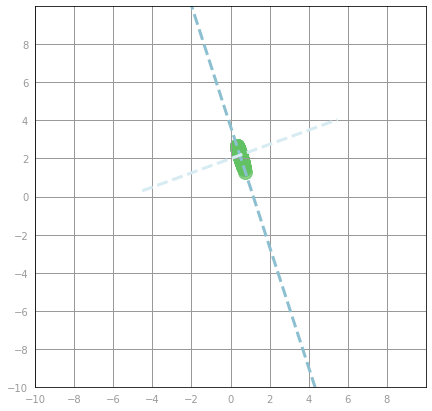

In [0]:
((x1_top, x2_top), (x1_second_top, x2_second_top), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(students_performance_data, top_components_correlated, 5)
# generate layout and plot data
fig, ax = prepare_plot(np.arange(-10, 10, 2), np.arange(-10, 10, 2), figsize=(7, 7))
ax.set_xlim(-10, 10), ax.set_ylim(-10, 10)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
# plt.scatter(student_performance_scores[:,0], student_performance_scores[:,1], s=14**2, c='#d6ebf2',
#             edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1_top, x2_top, s=14**2, c='#62c162', alpha=.75)

Out[114]: <matplotlib.collections.PathCollection at 0x7f4f955b89d0>

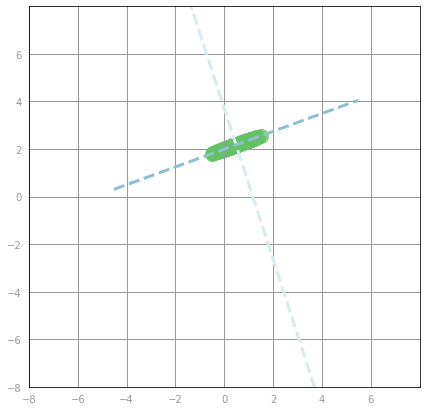

In [0]:
((x1_top, x2_top), (x1_second_top, x2_second_top), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(students_performance_data, top_components_correlated, 5)
# generate layout and plot data
fig, ax = prepare_plot(np.arange(-8, 8, 2), np.arange(-8, 8, 2), figsize=(7, 7))
ax.set_xlim(-8, 8), ax.set_ylim(-8, 8)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
# plt.scatter(students_performance_df.values[:,0], students_performance_df.values[:,1], s=14**2, c='#d6ebf2',
#             edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1_second_top, x2_second_top, s=14**2, c='#62c162', alpha=.75)